# University of London
## BSc in Computer Science Final Project
## De-Fake My News

#### By: Andres Salvador

## Dataset

My data set of choice is the ‘Fake and real news’ dataset available from the Kaggle official website (downloaded Feb 24, 2024):
https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection

This dataset has 2 csv files, True.csv and False.csv

Each csv file has 4 columns:

  1.   title: The title of the article
  2.   text: The text of the article
  3.   subject: The subject of the article
  4.   date: The date that this article was posted at

This dataset was chosen for the clarity and contents of the files.


Categorical Attributes

    subject: News, politics, left-news, Government News, US_News, Middle-east

Continuous Attributes

    date: continuous

# Initial Data Manipulation



## Library imports and file manipulation


In [ ]:
# Standard library imports
import os
import re
import shutil
import string
import warnings

# Third-party imports
from google.colab import drive
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D, Bidirectional, LSTM
from sklearn.preprocessing import LabelEncoder
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Warnings configuration
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# folder manipulation
dir = '/content/drive/MyDrive/NLP/extracts'

if os.path.exists(dir):
    shutil.rmtree(dir)

!mkdir dir

In [ ]:
# Unzipping the files, set to override for easy re-runs of the entire notebook
!unzip -o '/content/drive/MyDrive/NLP/Fake.csv.zip' -d '/content/drive/MyDrive/NLP/extracts'
!unzip -o '/content/drive/MyDrive/NLP/True.csv.zip' -d '/content/drive/MyDrive/NLP/extracts'

Archive:  /content/drive/MyDrive/NLP/Fake.csv.zip
  inflating: /content/drive/MyDrive/NLP/extracts/Fake.csv  
Archive:  /content/drive/MyDrive/NLP/True.csv.zip
  inflating: /content/drive/MyDrive/NLP/extracts/True.csv  


In [ ]:
# making sure the files are there
for dirname, _, filenames in os.walk('/content/drive/MyDrive/NLP/extracts'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/NLP/extracts/Fake.csv
/content/drive/MyDrive/NLP/extracts/True.csv


In [ ]:
# assigning the files to datasets
fake=pd.read_csv('/content/drive/MyDrive/NLP/extracts/Fake.csv')
real=pd.read_csv('/content/drive/MyDrive/NLP/extracts/True.csv')

## Quick look into the data

In [ ]:
# rows / columns
fake.shape

(23481, 4)

In [ ]:
# rows / columns
real.shape

(21417, 4)

In [ ]:
# quick look
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# quick look
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# Now, the fake news has this subjects and their count is
fake["subject"].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [ ]:
# Now, the real news has this subjects and their count is
real["subject"].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [ ]:
# How many different dates are there in the fake dataset
fake["date"].value_counts()

May 10, 2017                                                                                                                                             46
May 6, 2016                                                                                                                                              44
May 5, 2016                                                                                                                                              44
May 26, 2016                                                                                                                                             44
May 11, 2016                                                                                                                                             43
                                                                                                                                                         ..
https://100percentfedup.com/video-hillary-asked-about-trump-i-ju

In [ ]:
# How many different dates are there in the real dataset
real["date"].value_counts()

December 20, 2017      182
December 6, 2017       166
November 30, 2017      162
November 9, 2017       158
October 13, 2017       155
                      ... 
September 11, 2016       1
May 28, 2016             1
May 30, 2016             1
December 30, 2017        1
January 24, 2016         1
Name: date, Length: 716, dtype: int64

## Setting up Fake news

In [ ]:
# Lets add a label to the fake datasets, with 0 (as in how much we trust that row)
fake["label"]=0

Do we need to clean the dataset?

In [ ]:
# Of the fake dataset, how many rows have null values?
fake.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

No need to clean the fake data! But if needed to clean this dataset, we would have eliminated the empty rows, since this is text we cant replace the contents with mid/median values

In [ ]:
# Another quick look into the fake news, now with the label=0
fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Setting up Real News

In [ ]:
# Now lets work on the real dataset, lets add that label
real["label"]=1

Do we need to clean the dataset?

In [ ]:
# Of the real dataset, how many rows have null values?
real.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

No need to clean the real data! But if needed to clean this dataset, we would have eliminated the empty rows, since this is text we cant replace the contents with mid/median values

In [ ]:
# Another quick look into the real news, now with the label=1
real.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


## Individual Word cloud visual representation

The word count for all the true news text is:  9937110


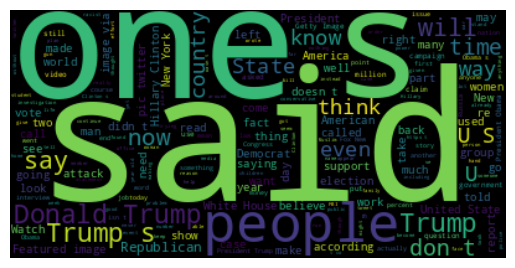

In [ ]:
# Now lets do it for the whole fake dataset
text_fake_all = " ".join(review for review in fake.text)

# The text might be too long to display, so lets just get the word count
print("The word count for all the true news text is: ", len(text_fake_all.split()))

# Lets generate the work cloud
wordcloud = WordCloud().generate(text_fake_all)

# Lets display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The word count for all the true news text is:  8259254


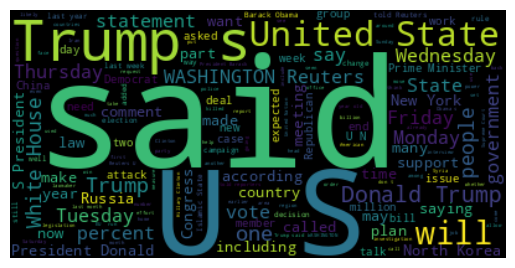

In [ ]:
# Now lets do it for the whole real dataset
text_real_all = " ".join(review for review in real.text)

# The text might be too long to display, so lets just get the word count
print("The word count for all the true news text is: ", len(text_real_all.split()))

# Lets generate the work cloud
wordcloud = WordCloud().generate(text_real_all)

# Lets display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Unifying the datasets

In [ ]:
# Now lets join the datasets into 1
data=pd.concat([fake,real],ignore_index=True)
data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
# Lets take a quick look at the joined dataset
data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
# The shape should only change in the rows
data.shape

(44898, 5)

In [ ]:
# Lets describe the dataset to get a better overview of the dataset
data.describe(include = 'all')

,title,text,subject,date,label
count,44898,44898,44898,44898,44898.000000
unique,38729,38646,8,2397,NaN
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",NaN
freq,14,627,11272,182,NaN
mean,NaN,NaN,NaN,NaN,0.477015
std,NaN,NaN,NaN,NaN,0.499477
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,1.000000


## Unified Dataset Word cloud visual representation

The word count for all the news text is:  18196364


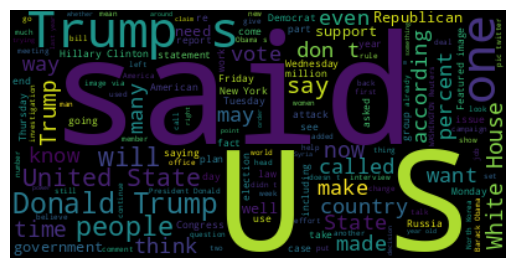

In [ ]:
# Now lets do it for the whole dataset
text_data = " ".join(review for review in data.text)

# The text might be too long to display, so lets just get the word count
print("The word count for all the news text is: ", len(text_data.split()))

# Lets generate the work cloud
wordcloud = WordCloud().generate(text_data)

# Lets display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Feature engineering

## Unsorting the data

In [ ]:
data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
data.tail()

,title,text,subject,date,label
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


After joining the datasets (real and fake), lets unsort them

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
data.head()

,title,text,subject,date,label
0,WEST VIRGINIA COAL MINERS Send A Clear Message...,West Virginia has been devastated by a loss of...,politics,"May 5, 2016",0
1,AWESOME! PRO-TRUMP LATINO Tells Horrors Of Soc...,THE SOCIALIST PRESIDENT WAS THIS GUY S TEACHER...,Government News,"Jun 9, 2016",0
2,NOT GRASSROOTS: #Ferguson Protestors PAID Over...,The Ferguson #BlackLivesMatter protesters are ...,politics,"May 17, 2015",0
3,Hillary Supporters Explained In 6 BRUTAL Photos,Hysterical With all the evidence available to ...,left-news,"Mar 3, 2016",0
4,Trump Was So Desperate During Last Debate He ...,CNN Money has released a report saying that Do...,News,"March 5, 2016",0


In [ ]:
data.tail()

,title,text,subject,date,label
44893,Narrowed travel ban could sow confusion in U.S...,WASHINGTON (Reuters) - The Supreme Court’s cri...,politicsNews,"June 26, 2017",1
44894,Trump Finally Watched Alec Baldwin Mock His R...,"It took Donald Trump all day, but he apparentl...",News,"January 15, 2017",0
44895,Sessions slams Chicago sanctuary policies,(Reuters) - U.S. Attorney General Jeff Session...,politicsNews,"August 16, 2017",1
44896,Togo security forces clash with protesters in ...,LOME (Reuters) - Security forces in Togo used ...,worldnews,"September 20, 2017",1
44897,Republican Ryan wants trade talks with Britain,"WASHINGTON (Reuters) - Paul Ryan, the Speaker ...",politicsNews,"June 28, 2016",1


## Removing punctuation from the text

By taking out punctuation, you cut down on the extra stuff in the data. This makes it simpler for the algorithms to pay attention to the main words and what they mean.

In [ ]:
# Lets remove the puntiation from the text
# from https://stackoverflow.com/questions/53664775/how-to-remove-punctuation-in-python
# and https://www.geeksforgeeks.org/python-remove-punctuation-from-string/

# Procedure to remove punctuation
def clearPunctuation(text: str) -> str:
    incommingText = text.encode("utf8").decode("ascii",'ignore')
    listOfCharactersWithoutPunctuation = [ch for ch in incommingText if ch not in string.punctuation]
    stringWithoutPunctuation = ''.join(listOfCharactersWithoutPunctuation)
    # Remove trailing spaces
    stringWithoutPunctuation = stringWithoutPunctuation.strip()

    return stringWithoutPunctuation

# adding a column to my dataset, a no-punctuation column
data['no_puntuation_text'] = data['text'].apply(clearPunctuation)

Taking a look at the original data

In [ ]:
original_text = data['text']
original_text.head()

0    West Virginia has been devastated by a loss of...
1    THE SOCIALIST PRESIDENT WAS THIS GUY S TEACHER...
2    The Ferguson #BlackLivesMatter protesters are ...
3    Hysterical With all the evidence available to ...
4    CNN Money has released a report saying that Do...
Name: text, dtype: object

Taking a look at the cleaned data

In [ ]:
cleaned_text = data['no_puntuation_text']
cleaned_text.head()

0    West Virginia has been devastated by a loss of...
1    THE SOCIALIST PRESIDENT WAS THIS GUY S TEACHER...
2    The Ferguson BlackLivesMatter protesters are s...
3    Hysterical With all the evidence available to ...
4    CNN Money has released a report saying that Do...
Name: no_puntuation_text, dtype: object

## Lowercasing the text

In [ ]:
# Seeting up the column with lowercase text
data['lowercase_text'] = data['no_puntuation_text'].str.lower()

What we had before

In [ ]:
data['no_puntuation_text'].head()

0    West Virginia has been devastated by a loss of...
1    THE SOCIALIST PRESIDENT WAS THIS GUY S TEACHER...
2    The Ferguson BlackLivesMatter protesters are s...
3    Hysterical With all the evidence available to ...
4    CNN Money has released a report saying that Do...
Name: no_puntuation_text, dtype: object

What we have now

In [ ]:
data['lowercase_text'].head()

0    west virginia has been devastated by a loss of...
1    the socialist president was this guy s teacher...
2    the ferguson blacklivesmatter protesters are s...
3    hysterical with all the evidence available to ...
4    cnn money has released a report saying that do...
Name: lowercase_text, dtype: object

## Removing the double spaces

The other steps left double spaces in the text column, lets remove them

In [ ]:
# taken and modified from: https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string
def remove_double_spaces(text):
    return re.sub(r'\s+', ' ', text)

# Lets add another column, now one without doble empty spaces
data['no_double_spaces'] = data['lowercase_text'].apply(remove_double_spaces)

In [ ]:
data['lowercase_text'].head()

0    west virginia has been devastated by a loss of...
1    the socialist president was this guy s teacher...
2    the ferguson blacklivesmatter protesters are s...
3    hysterical with all the evidence available to ...
4    cnn money has released a report saying that do...
Name: lowercase_text, dtype: object

In [ ]:
data['no_double_spaces'].head()

0    west virginia has been devastated by a loss of...
1    the socialist president was this guy s teacher...
2    the ferguson blacklivesmatter protesters are s...
3    hysterical with all the evidence available to ...
4    cnn money has released a report saying that do...
Name: no_double_spaces, dtype: object

## Removing Stopwords

Now, lets remove the stopwords from the text

In [ ]:
# taken and modified from: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_sentence)

# lets add another column, now one with no stopwords
data['no_stopwords'] = data['no_double_spaces'].apply(remove_stopwords)

In [ ]:
data['no_stopwords'].head()

0    west virginia devastated loss 10000 jobs due o...
1    socialist president guy teacher great encounte...
2    ferguson blacklivesmatter protesters spilling ...
3    hysterical evidence available american voters ...
4    cnn money released report saying donald trump ...
Name: no_stopwords, dtype: object

It is clean now!

## Adding a Sentiment analysis to the dataset

In [ ]:
# Taken and modified from: https://stackoverflow.com/questions/57803412/applying-sentimentintensityanalyzer-function-on-each-row-of-the-dataframe-prov

# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Lets add another column, but now with the sentiment analysis
data['text_sentiment'] = data['no_stopwords'].apply(get_sentiment)

In [ ]:
data.head()

,title,text,subject,date,label,no_puntuation_text,lowercase_text,no_double_spaces,no_stopwords,text_sentiment
0,WEST VIRGINIA COAL MINERS Send A Clear Message...,West Virginia has been devastated by a loss of...,politics,"May 5, 2016",0,West Virginia has been devastated by a loss of...,west virginia has been devastated by a loss of...,west virginia has been devastated by a loss of...,west virginia devastated loss 10000 jobs due o...,-0.8225
1,AWESOME! PRO-TRUMP LATINO Tells Horrors Of Soc...,THE SOCIALIST PRESIDENT WAS THIS GUY S TEACHER...,Government News,"Jun 9, 2016",0,THE SOCIALIST PRESIDENT WAS THIS GUY S TEACHER...,the socialist president was this guy s teacher...,the socialist president was this guy s teacher...,socialist president guy teacher great encounte...,0.8481
2,NOT GRASSROOTS: #Ferguson Protestors PAID Over...,The Ferguson #BlackLivesMatter protesters are ...,politics,"May 17, 2015",0,The Ferguson BlackLivesMatter protesters are s...,the ferguson blacklivesmatter protesters are s...,the ferguson blacklivesmatter protesters are s...,ferguson blacklivesmatter protesters spilling ...,-0.9893
3,Hillary Supporters Explained In 6 BRUTAL Photos,Hysterical With all the evidence available to ...,left-news,"Mar 3, 2016",0,Hysterical With all the evidence available to ...,hysterical with all the evidence available to ...,hysterical with all the evidence available to ...,hysterical evidence available american voters ...,0.9118
4,Trump Was So Desperate During Last Debate He ...,CNN Money has released a report saying that Do...,News,"March 5, 2016",0,CNN Money has released a report saying that Do...,cnn money has released a report saying that do...,cnn money has released a report saying that do...,cnn money released report saying donald trump ...,-0.8484


Interesting, values are between -1 for bad/sad news and +1 for good/happy news

### Sentiment Analysis on Fake News

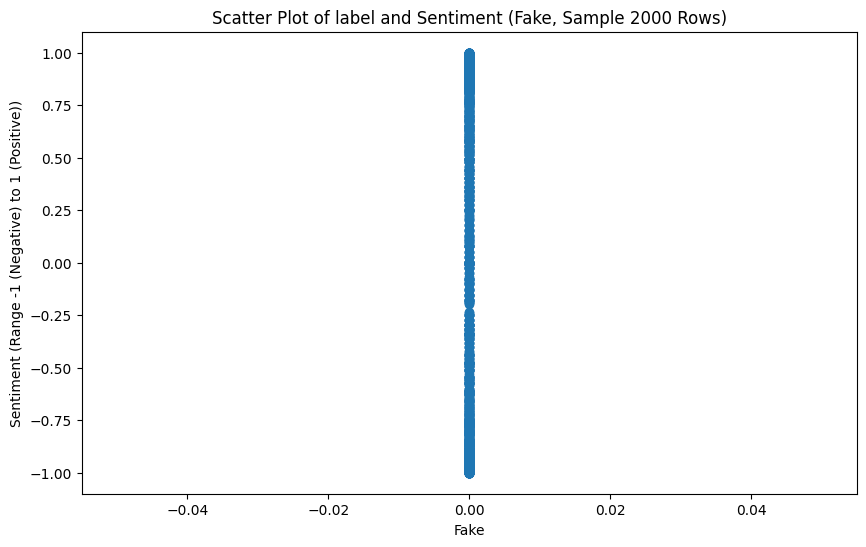

In [ ]:
# Let's get a sample of Real news and test it against a Sentiment analysis
df_filtered_fake = data[data['label'] == 0]

#Lets limit that to 2000 values, just to graph a sample
df_limited_fake = df_filtered_fake.sample(2000)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_limited_fake['label'], df_limited_fake['text_sentiment'])

# Adding titles and labels
plt.title('Scatter Plot of label and Sentiment (Fake, Sample 2000 Rows)')
plt.xlabel('Fake')
plt.ylabel('Sentiment (Range -1 (Negative) to 1 (Positive))')

# Show the plot
plt.show()

This seems well distributed, no actual skewness.

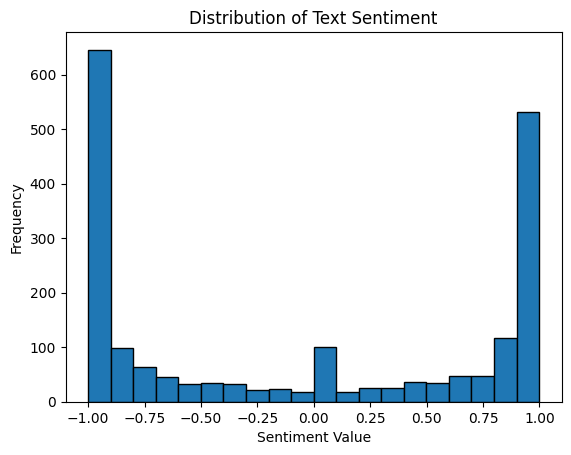

In [ ]:
plt.hist(df_limited_fake['text_sentiment'], bins=20, edgecolor='black')

plt.title('Distribution of Text Sentiment')
plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.show()

Now we can see that the sample data leans more to the negative/sad/bad news, but not by much.

Let's examine the whole of the fake news.

In [ ]:
# Calculate min, median, max, and mean (average) of Column2
min_val = df_filtered_fake['text_sentiment'].min()
median_val = df_filtered_fake['text_sentiment'].median()
max_val = df_filtered_fake['text_sentiment'].max()
mean_val = df_filtered_fake['text_sentiment'].mean()

(min_val, median_val, max_val, mean_val)

(-1.0, -0.0772, 0.9999, -0.05652798858651677)

This suggests that in this dataset, Fake News tends more to the negative side, but by a little bit.

### Sentiment Analysis on Real News

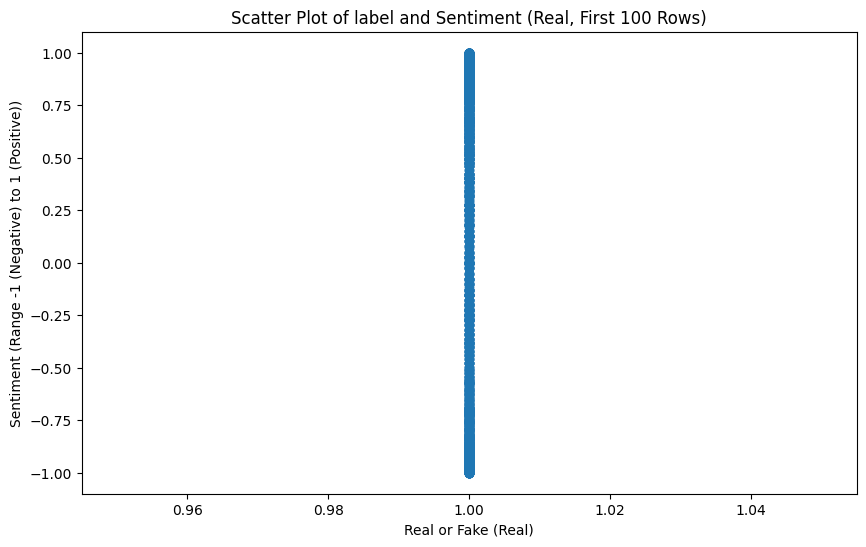

In [ ]:
# Let's get a sample of Real news and test it against a Sentiment analysis
df_filtered_real = data[data['label'] == 1]

#Lets limit that to 200 values, just to graph
df_limited_real = df_filtered_real.sample(2000)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_limited_real['label'], df_limited_real['text_sentiment'])

# Adding titles and labels
plt.title('Scatter Plot of label and Sentiment (Real, First 100 Rows)')
plt.xlabel('Real or Fake (Real)')
plt.ylabel('Sentiment (Range -1 (Negative) to 1 (Positive))')

# Show the plot
plt.show()

This seems well distributed too, no actual skewness.

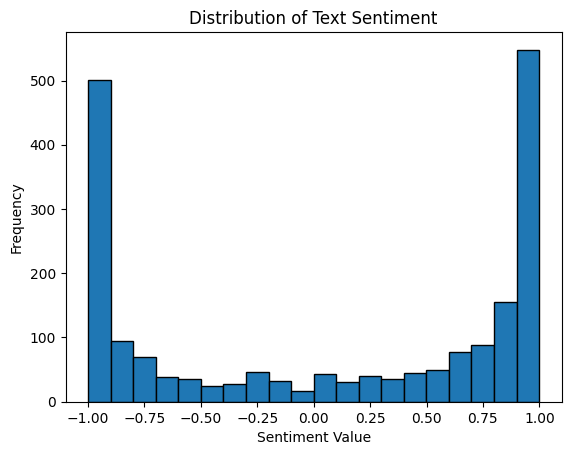

In [ ]:
plt.hist(df_limited_real['text_sentiment'], bins=20, edgecolor='black')

plt.title('Distribution of Text Sentiment')
plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.show()

Now we can see that the sample data leans more to the positive news, but not by much.

Let's examine whether Real News tends to be more positive overall.

In [ ]:
# Calculate min, median, max, and mean (average) of Column2
min_val = df_filtered_real['text_sentiment'].min()
median_val = df_filtered_real['text_sentiment'].median()
max_val = df_filtered_real['text_sentiment'].max()
mean_val = df_filtered_real['text_sentiment'].mean()

(min_val, median_val, max_val, mean_val)

(-0.9997, 0.3182, 0.9999, 0.08324935798664612)

This indicates that in this dataset, Real News is generally more positive.

#### Sentiment Analysis Conclusion
Let's note the caveat that this observation is specific to this dataset and should not be used as a standard to compare real versus fake news across the entire news landscape.
That being said, there is no distinct or big enough correlation between the positivity or negativity of content and its classification as real or fake news in this dataset. Real news looked more positive and fake news more negative, but the margins are really small.
However, there is a slight trend: positive news leans towards being positive, while fake news tends to be more negative.


## Adding Character Level Features to the dataset

In [ ]:
#Taken and modified from: https://www.geeksforgeeks.org/count-uppercase-lowercase-special-character-numeric-values/

# Feature Extraction Functions

def count_characters(text):
    return len(text)

def count_digits(text):
    return sum(c.isdigit() for c in text)

def count_uppercase(text):
    return sum(c.isupper() for c in text)

# Applying the functions to the DataFrame
data['char_count'] = data['no_stopwords'].apply(count_characters)
data['digit_count'] = data['no_stopwords'].apply(count_digits)
data['uppercase_count'] = data['no_stopwords'].apply(count_uppercase)

In [ ]:
# Display the char_count
print(data['char_count'])

0         171
1          89
2        1270
3         377
4        1342
         ... 
44893    3216
44894    2675
44895    1804
44896    1913
44897    1137
Name: char_count, Length: 44898, dtype: int64


In [ ]:
# Calculate min, median, max, and mean (average) of char_count
min_val = data['char_count'].min()
median_val = data['char_count'].median()
max_val = data['char_count'].max()
mean_val = data['char_count'].mean()

(min_val, median_val, max_val, mean_val)

(0, 1531.0, 38910, 1751.3913760078399)

In [ ]:
# # Display the digit_count
print(data['digit_count'])

0         5
1         0
2        13
3         0
4         0
         ..
44893     6
44894    91
44895    29
44896    14
44897     2
Name: digit_count, Length: 44898, dtype: int64


In [ ]:
# Calculate min, median, max, and mean (average) of Column2
min_val = data['digit_count'].min()
median_val = data['digit_count'].median()
max_val = data['digit_count'].max()
mean_val = data['digit_count'].mean()

(min_val, median_val, max_val, mean_val)

(0, 9.0, 1396, 16.14978395474186)

In [ ]:
# Display the uppercase_count
print(data['uppercase_count'])

0        0
1        0
2        0
3        0
4        0
        ..
44893    0
44894    0
44895    0
44896    0
44897    0
Name: uppercase_count, Length: 44898, dtype: int64


In [ ]:
# Calculate min, median, max, and mean (average) of Column2
min_val = data['uppercase_count'].min()
median_val = data['uppercase_count'].median()
max_val = data['uppercase_count'].max()
mean_val = data['uppercase_count'].mean()

(min_val, median_val, max_val, mean_val)

(0, 0.0, 0, 0.0)

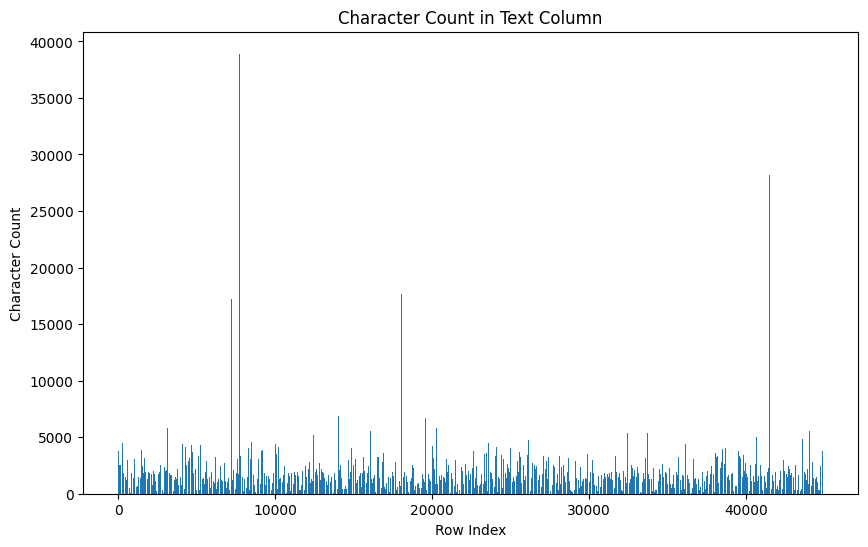

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.bar(data.index, data['char_count'])
plt.xlabel('Row Index')
plt.ylabel('Character Count')
plt.title('Character Count in Text Column')
plt.show()

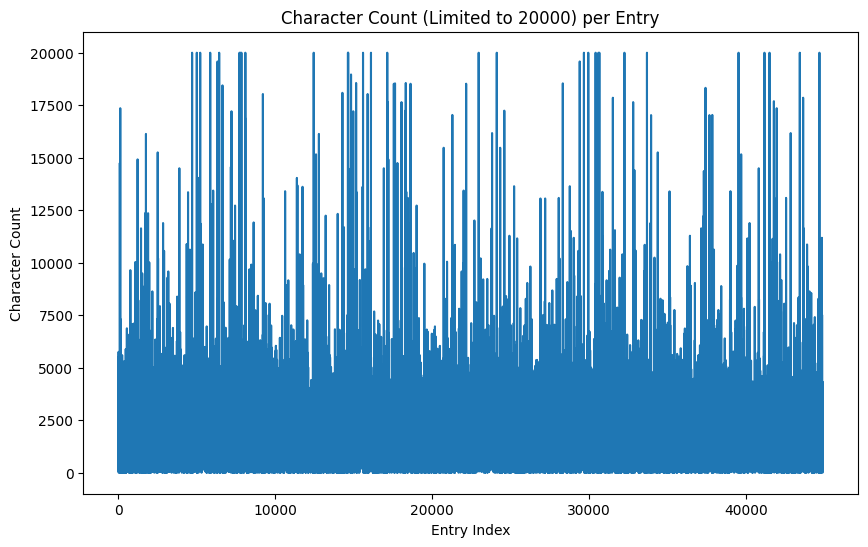

In [ ]:
# Limiting the character count to 20000
data['char_count_limited'] = data['char_count'].clip(upper=20000)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['char_count_limited'])
plt.title('Character Count (Limited to 20000) per Entry')
plt.xlabel('Entry Index')
plt.ylabel('Character Count')
plt.show()

### CLF on Fake news

In [ ]:
# Taken and adapted from https://stackoverflow.com/questions/55249360/count-the-number-of-digits-in-a-dataframe-column

# Now just for Fake news
df_filtered_fake = data[data['label'] == 0]
# Applying the functions to the DataFrame
data['char_count'] = df_filtered_fake['no_puntuation_text'].apply(count_characters)
data['digit_count'] = df_filtered_fake['no_puntuation_text'].apply(count_digits)
data['uppercase_count'] = df_filtered_fake['no_puntuation_text'].apply(count_uppercase)

# Display the DataFrame
print(df_filtered_fake['char_count'])

0         171
1          89
2        1270
3         377
4        1342
         ... 
44888    1871
44889    3680
44890     960
44892    1376
44894    2675
Name: char_count, Length: 23481, dtype: int64


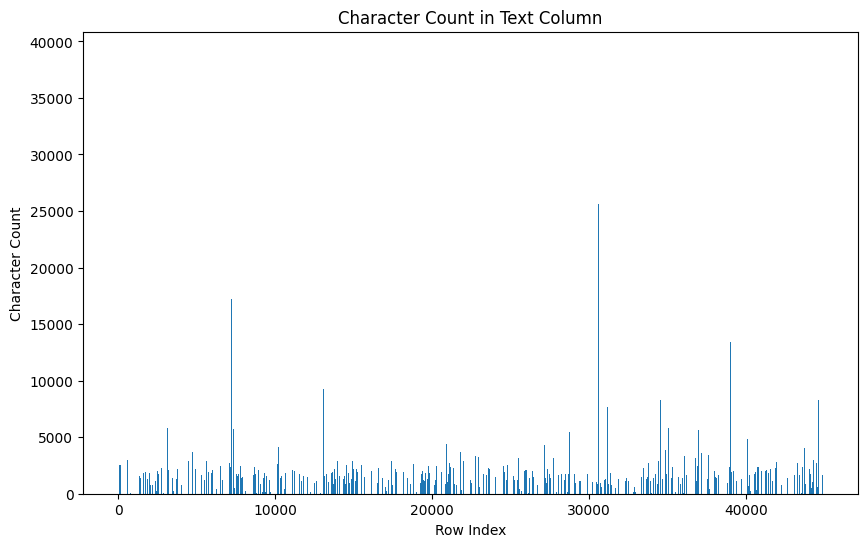

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.bar(df_filtered_fake.index, df_filtered_fake['char_count'])
plt.xlabel('Row Index')
plt.ylabel('Character Count')
plt.title('Character Count in Text Column')
plt.show()

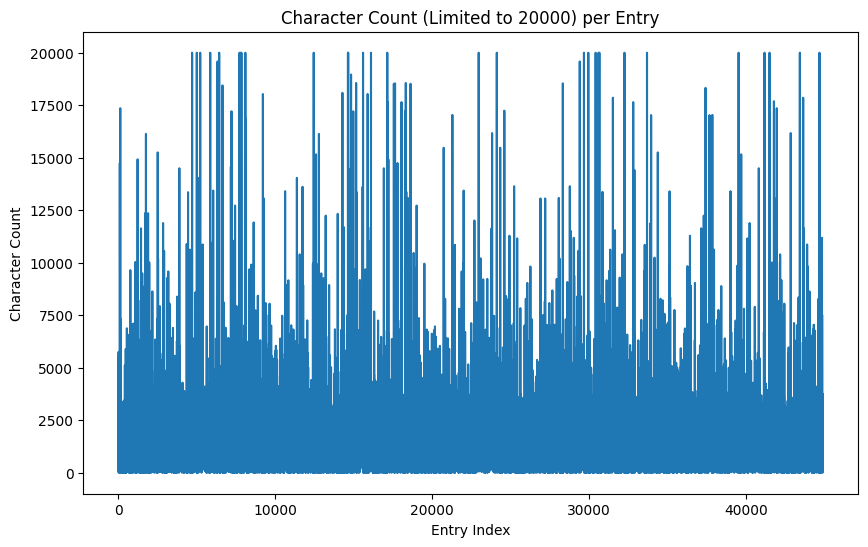

In [ ]:
# Limiting the character count to 20000
df_filtered_fake['char_count_limited'] = df_filtered_fake['char_count'].clip(upper=20000)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_filtered_fake.index, df_filtered_fake['char_count_limited'])
plt.title('Character Count (Limited to 20000) per Entry')
plt.xlabel('Entry Index')
plt.ylabel('Character Count')
plt.show()

### CLF on Real news

In [ ]:
# Now just for Real news
df_filtered_true = data[data['label'] == 1]
# Applying the functions to the DataFrame
df_filtered_true['char_count'] = df_filtered_true['no_stopwords'].apply(count_characters)
df_filtered_true['digit_count'] = df_filtered_true['no_stopwords'].apply(count_digits)
df_filtered_true['uppercase_count'] = df_filtered_true['no_stopwords'].apply(count_uppercase)

# Display the DataFrame
print(df_filtered_true['char_count'])

7        3796
10       1854
11       2416
12       2233
16        526
         ... 
44891    3311
44893    3216
44895    1804
44896    1913
44897    1137
Name: char_count, Length: 21417, dtype: int64


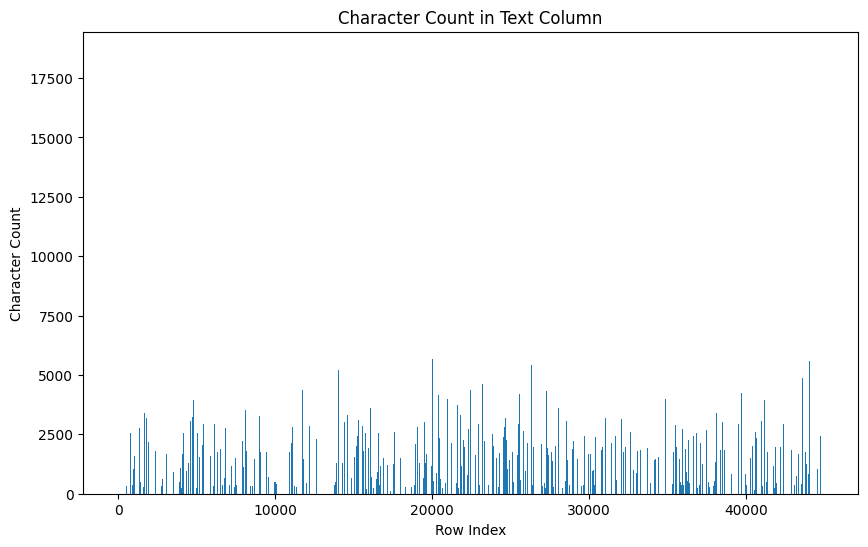

In [ ]:
# Plotting
plt.figure(figsize=(10,6))
plt.bar(df_filtered_true.index, df_filtered_true['char_count'])
plt.xlabel('Row Index')
plt.ylabel('Character Count')
plt.title('Character Count in Text Column')
plt.show()

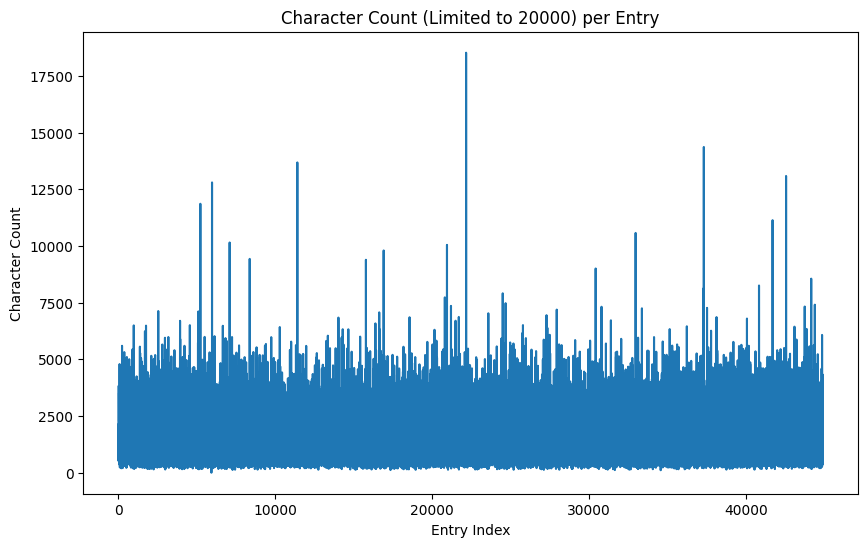

In [ ]:
# Limiting the character count to 20000
df_filtered_true['char_count_limited'] = df_filtered_true['char_count'].clip(upper=20000)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_filtered_true.index, df_filtered_true['char_count_limited'])
plt.title('Character Count (Limited to 20000) per Entry')
plt.xlabel('Entry Index')
plt.ylabel('Character Count')
plt.show()

#### CLF Conclusion
In this dataset, it seems that Fake News exhibits a more even distribution of character counts.

# NLP Model Training


## Bayes on raw data

The model Accuracy is:  0.5672605790645879
The model F1 is:  0.5360923199363311
The model Precision is:  0.519833307609199
The model Recall is:  0.5534012487676635


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

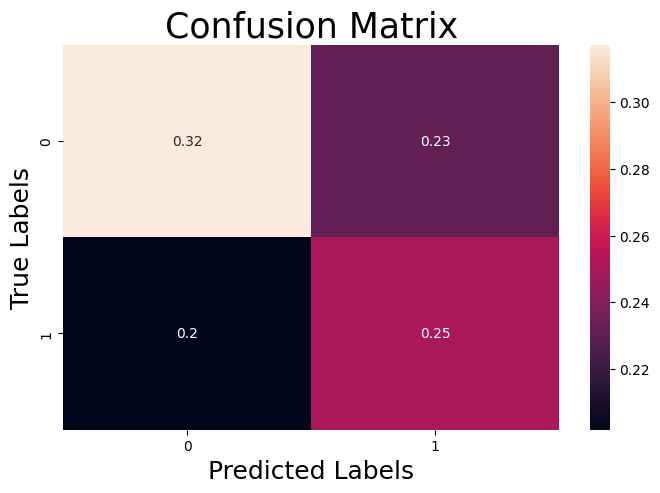

In [ ]:
# Taken and adapted from: https://www.geeksforgeeks.org/multinomial-naive-bayes/

# Let's get everything ready for using the multinomial Naive Bayes classifier
# (Bayes for text)
# Features are the text of the news
features_raw = data['text']
# Targets are the values 0 for fake and 1 for true
targets_raw = data['label']

# Let's split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features_raw, targets_raw,
                                                    test_size=0.30,
                                                    random_state=13)

# Since we are want to predict using words, rather than numbers, we need to
# limit the word vocabulary and we need to set the tokenizer to limit the max
# amount of the vocabulary
max_vocabulary = 10000
tokenizer = Tokenizer(num_words=max_vocabulary)
tokenizer.fit_on_texts(X_train)

# Now let's use the tokenizer to turn text into lists
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# This pads the sequences to make them the same length, we need this for processing the data
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

# Creating the model, in this case Bayes
bayes_model = MultinomialNB()

# Fitting the model with the train data
bayes_model.fit(X_train, y_train)

# Predicting
predicted_bayes_model = bayes_model.predict(X_test)

# Checking values
print("The model Accuracy is: ", accuracy_score(predicted_bayes_model, y_test))
print("The model F1 is: ", f1_score(predicted_bayes_model, y_test))
print("The model Precision is: ", precision_score(predicted_bayes_model, y_test))
print("The model Recall is: ", recall_score(predicted_bayes_model, y_test))

# Now let's try to graph that model

# This is where I'll store the predictions
binary_predictions = []

# Let's place the predicted values into buckets and then into my storage
for i in predicted_bayes_model:
    # If it was higher/equal to 0.5, it's a 1 (true)
    if i >= 0.5:
        binary_predictions.append(1)
    # It's false
    else:
        binary_predictions.append(0)

# Let's fill out the confusion matrix with values
matrix_of_confusion = confusion_matrix(binary_predictions, y_test, normalize='all')

# Let's plot it (standard 8 by 5)
plt.figure(figsize=(8, 5))

matrix_graph = plt.subplot()
# Adding a heat map
sns.heatmap(matrix_of_confusion, annot=True, ax = matrix_graph)
# Labeling and prettying it up
matrix_graph.set_xlabel('Predicted Labels', size=18)
matrix_graph.set_ylabel('True Labels', size=18)
matrix_graph.set_title('Confusion Matrix', size=25)
matrix_graph.xaxis.set_ticklabels([0,1], size=10)
matrix_graph.yaxis.set_ticklabels([0,1], size=10)



## Bayes on cleaned data

The model Accuracy is:  0.5752041573867854
The model F1 is:  0.5569149759950442
The model Precision is:  0.5550239234449761
The model Recall is:  0.5588189588189588


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

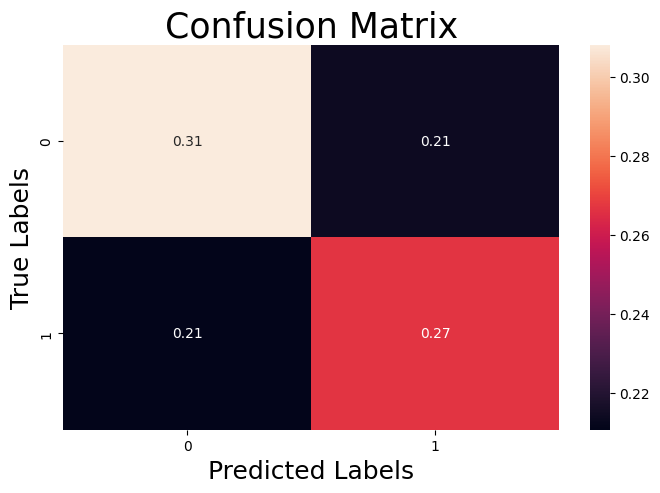

In [ ]:
# Let's get everything ready for using the multinomial Naive Bayes classifier
# (Bayes for text)
# Features are the text of the news
features = data['no_puntuation_text']
# Targets are the values 0 for fake and 1 for true
targets = data['label']

# Let's split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features, targets,
                                                    test_size=0.30,
                                                    random_state=13)

# Since we are want to predict using words, rather than numbers, we need to
# limit the word vocabulary
# and we need to set the tokenizer to limit the max amount of the vocabulary
max_vocabulary = 10000
tokenizer = Tokenizer(num_words=max_vocabulary)
tokenizer.fit_on_texts(X_train)

# Now let's use the tokenizer to turn text into lists
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# This pads the sequences to make them the same length, we need this for
# processing the data
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post',
                                                        maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post',
                                                       maxlen=256)

# Creating the model, in this case Bayes
bayes_model = MultinomialNB()

# Fitting the model with the train data
bayes_model.fit(X_train, y_train)

# Predicting
predicted_bayes_model = bayes_model.predict(X_test)

# Checking values
print("The model Accuracy is: ", accuracy_score(predicted_bayes_model, y_test))
print("The model F1 is: ", f1_score(predicted_bayes_model, y_test))
print("The model Precision is: ", precision_score(predicted_bayes_model, y_test))
print("The model Recall is: ", recall_score(predicted_bayes_model, y_test))

# Now let's try to graph that model

# This is where I'll store the predictions
binary_predictions = []

# Let's place the predicted values into buckets and then into my storage
for i in predicted_bayes_model:
    # If it was higher/equal to 0.5, it's a 1 (true)
    if i >= 0.5:
        binary_predictions.append(1)
    # It's false
    else:
        binary_predictions.append(0)

# Let's fill out the confusion matrix with values
matrix_of_confusion = confusion_matrix(binary_predictions, y_test,
                                       normalize='all')

# Let's plot it (standard 8 by 5)
plt.figure(figsize=(8, 5))

matrix_graph = plt.subplot()
# Adding a heat map
sns.heatmap(matrix_of_confusion, annot=True, ax = matrix_graph)
# Labeling and prettying it up
matrix_graph.set_xlabel('Predicted Labels', size=18)
matrix_graph.set_ylabel('True Labels', size=18)
matrix_graph.set_title('Confusion Matrix', size=25)
matrix_graph.xaxis.set_ticklabels([0,1], size=10)
matrix_graph.yaxis.set_ticklabels([0,1], size=10)


### Conclusion on Bayesian Analysis

It appears that there is a slight improvement in the accuracy of True predictions when using data without punctuation, while the rest of the results remain largely unchanged.

## SimpleRNN

### On raw data

421/421 [==============================] - 5s 12ms/step


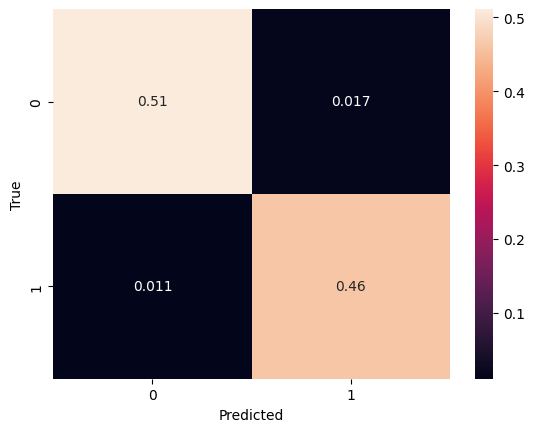

421/421 [==============================] - 6s 13ms/step - loss: 0.1209 - accuracy: 0.9722
Test Accuracy: 97.22%


In [ ]:
# Taken and adapted from: https://subscription.packtpub.com/book/data/9781788292061/7/ch07lvl1sec57/simple-rnn-with-keras

# Features are the text of the news
features_raw = data['text']
# Targets are the labels
targets_raw = data['label']

# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features_raw, targets_raw, test_size=0.30)

# Basic tokenization and conversion to sequences, limit to 100 words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train[:100])
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Basic padding of sequences
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

# Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32),
    tf.keras.layers.SimpleRNN(10),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.1)

# Evaluate the model
model.evaluate(X_test, y_test)

# Predict and generate binary predictions
predicted = model.predict(X_test)
binary_predictions = [1 if x >= 0.5 else 0 for x in predicted]

# Generate a confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, binary_predictions, normalize='all')
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

### On cleaned data

421/421 [==============================] - 4s 10ms/step


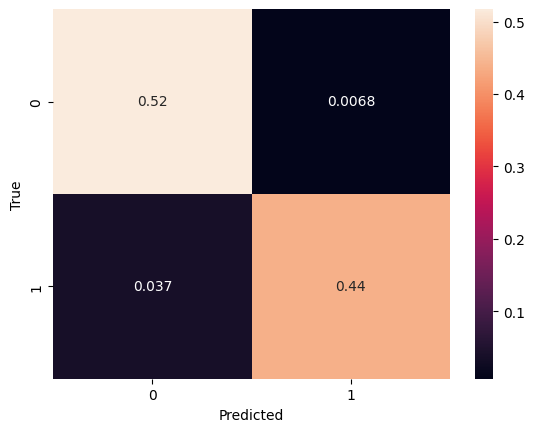

421/421 [==============================] - 5s 13ms/step - loss: 0.1542 - accuracy: 0.9564
Test Accuracy: 95.64%


In [ ]:
# Features are the text of the news
features_clean = data['no_puntuation_text']
# Targets are labels
targets_clean = data['label']

# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features_clean, targets_clean, test_size=0.30)

# Basic tokenization and conversion to sequences, limit to 100 words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train[:100])
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Basic padding of sequences
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

# Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32),
    tf.keras.layers.SimpleRNN(10),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.1)

# Evaluate the model
model.evaluate(X_test, y_test)

# Predict and generate binary predictions
predicted = model.predict(X_test)
binary_predictions = [1 if x >= 0.5 else 0 for x in predicted]

# Generate a confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, binary_predictions, normalize='all')
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

#### Conclusion on SimpleRNN

On raw data, we get an accuracy of: 97.22%

On cleaned data, we get an accuracy of: 95.64%

In SimpleRNN cleaning the data does affect the accurary of the trained models, in the wrong way!

## GRU

### On raw data

421/421 [==============================] - 2s 3ms/step


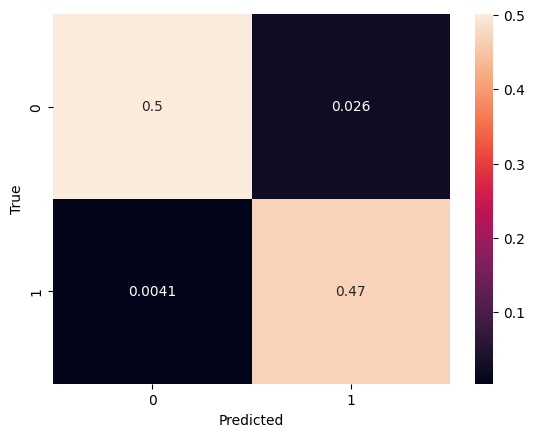

421/421 [==============================] - 2s 4ms/step - loss: 0.0890 - accuracy: 0.9699
Test Accuracy: 96.99%


In [ ]:
# Taken and adapted from: https://keras.io/api/layers/recurrent_layers/gru/

# Features are the text of the news
features_raw = data['text']
# Targets are the labels
targets_raw = data['label']

# Split the data into train and test datasets (simpler split)
X_train, X_test, y_train, y_test = train_test_split(features_raw, targets_raw, test_size=0.30)

# Basic tokenization and conversion to sequences, limit to 100 words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train[:100])
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Basic padding of sequences
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

# Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32),
    tf.keras.layers.GRU(16),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.1)

# Evaluate the model
model.evaluate(X_test, y_test)

# Predict and generate binary predictions
predicted = model.predict(X_test)
binary_predictions = [1 if x >= 0.5 else 0 for x in predicted]

# Generate a confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, binary_predictions, normalize='all')
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

### On cleaned data

421/421 [==============================] - 2s 3ms/step


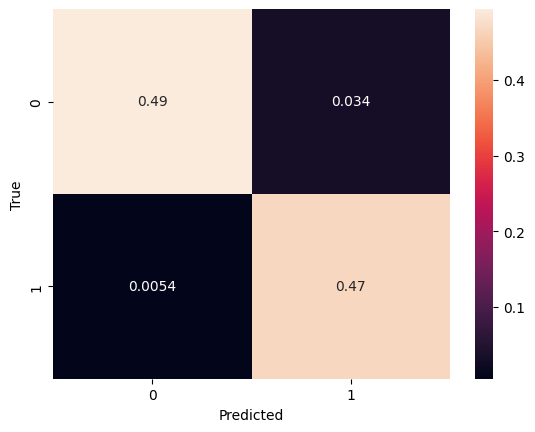

421/421 [==============================] - 2s 4ms/step - loss: 0.1163 - accuracy: 0.9606
Test Accuracy: 96.06%


In [ ]:
# Features are the text of the news
features_clean = data['no_puntuation_text']
# Targets are the labels
targets_clean = data['label']

# Split the data into train and test datasets (simpler split)
X_train, X_test, y_train, y_test = train_test_split(features_clean, targets_clean, test_size=0.30)

# Basic tokenization and conversion to sequences, limit to 100 words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train[:100])
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Basic padding of sequences
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

# Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 32),
    tf.keras.layers.GRU(16),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1, batch_size=128, validation_split=0.1)

# Evaluate the model
model.evaluate(X_test, y_test)

# Predict and generate binary predictions
predicted = model.predict(X_test)
binary_predictions = [1 if x >= 0.5 else 0 for x in predicted]

# Generate a confusion matrix and plot it
conf_matrix = confusion_matrix(y_test, binary_predictions, normalize='all')
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

#### Conclusion on GRU

On raw data, we get an accuracy of: 96.99%

On cleaned data, we get an accuracy of: 96.06%

In GRU cleaning the data affect the accurary, it is more accurate to use the raw data!

## LSTM


### On raw data

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1300737 (4.96 MB)
Trainable params: 1300737 (4.96 MB)
Non-trainable params: 0 (0.00 Byte)
________________

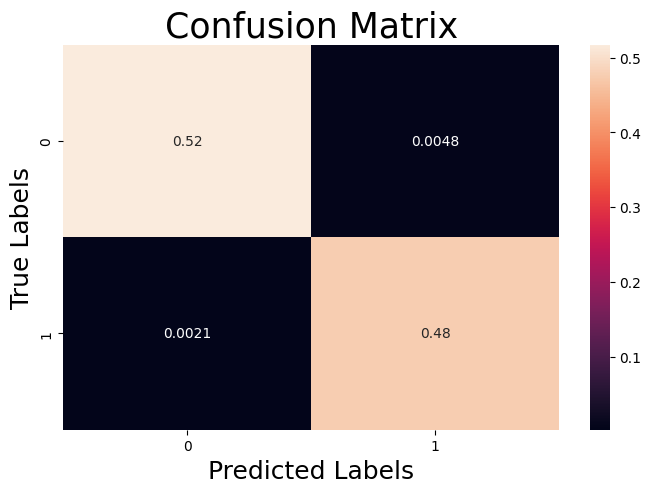

In [ ]:
# Taken and adapted from: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

# features are the text of the news
features_raw = data['text']
# targets are labels
targets_raw = data['label']

# Let's split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features_raw, targets_raw,
                                                    test_size=0.30, random_state=7)

# Since we want to predict using words rather than numbers, we need to limit the word vocabulary
# and we need to set the tokenizer to limit the max amount of the vocabulary
max_vocabulary = 10000
tokenizer = Tokenizer(num_words=max_vocabulary)
tokenizer.fit_on_texts(X_train)

# Now, let's use the tokenizer to turn text into lists
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# This pads the sequences to make them the same length; we need this for processing the data
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post',
                                                        maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post',
                                                       maxlen=256)

# Let's create the model now!
model = tf.keras.Sequential([
    # This is the embedding layer, to convert into dense vectors for better input
    tf.keras.layers.Embedding(max_vocabulary, 128),
    # This will process the input in both directions; it helps with work context
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # This is technical, but it applies a non-linear transformation to the inputs
    # using the ReLU activation function
    tf.keras.layers.Dense(64, activation='relu'),
    # This prevents overfitting by setting a fraction of the inputs as 0
    tf.keras.layers.Dropout(0.5),
    # This predicts the final value
    tf.keras.layers.Dense(1)
])

# Let's print a summary of the model
model.summary()

# Let's compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

# Let's fit the model
model_fitter = model.fit(X_train, y_train, epochs=1, validation_split=0.1,
                         batch_size=30, shuffle=True)


# Let's evaluate it
model.evaluate(X_test, y_test)

# Lets predict something
predicted_LSTM_model = model.predict(X_test)

# Now let's try to graph that model

# This is where I'll store the predictions
binary_predictions = []

# Let's place the predicted values into buckets and then into my storage
for i in predicted_LSTM_model:
    # If it was higher/equal to 0.5, it's a 1 (true)
    if i >= 0.5:
        binary_predictions.append(1)
    # It's false
    else:
        binary_predictions.append(0)

# lets fill out the confusion matrix with values
matrix_of_confusion = confusion_matrix(binary_predictions, y_test,
                                       normalize='all')

# Lets plot it (standard eight by 5)
plt.figure(figsize=(8, 5))

matrix_graph = plt.subplot()
# Adding a heat map
sns.heatmap(matrix_of_confusion, annot=True, ax = matrix_graph)
# Labeling and prettying it up
matrix_graph.set_xlabel('Predicted Labels', size=18)
matrix_graph.set_ylabel('True Labels', size=18)
matrix_graph.set_title('Confusion Matrix', size=25)
matrix_graph.xaxis.set_ticklabels([0,1], size=10)
matrix_graph.yaxis.set_ticklabels([0,1], size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

### On cleaned data

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1300737 (4.96 MB)
Trainable params: 1300737 (4.96 MB)
Non-trainable params: 0 (0.00 Byte)
________________

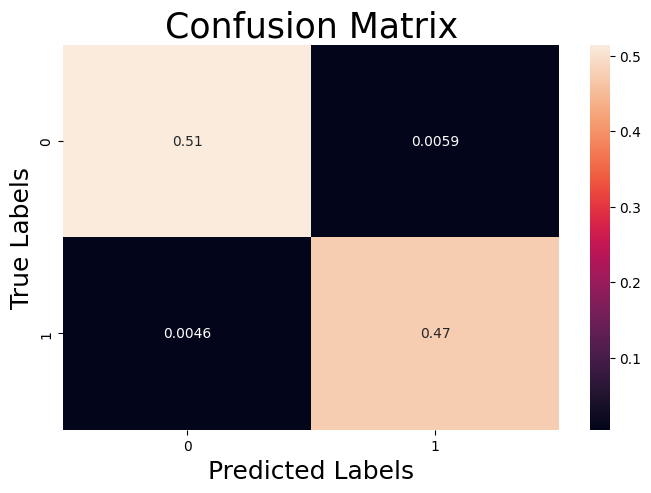

In [ ]:
# Let's get everything ready for using the multinomial Naive Bayes classifier (Bayes for text)
# features are the text of the news
features_raw = data['no_puntuation_text']
# targets are the values 0 for fake and 1 for true
targets_raw = data['label']

# Let's split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.30, random_state=7)

# Since we want to predict using words rather than numbers, we need to limit the word vocabulary
# and we need to set the tokenizer to limit the max amount of the vocabulary
max_vocabulary = 10000
tokenizer = Tokenizer(num_words=max_vocabulary)
tokenizer.fit_on_texts(X_train)

# Now, let's use the tokenizer to turn text into lists
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# This pads the sequences to make them the same length; we need this for processing the data
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

# Features are the text of the news
features = data['no_puntuation_text']
# Targets are the values 0 for fake and 1 for true
targets = data['label']

# Let's create the model now!
model = tf.keras.Sequential([
    # This is the embedding layer, to convert into dense vectors for better input
    tf.keras.layers.Embedding(max_vocabulary, 128),
    # This will process the input in both directions; it helps with work context
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # This is technical, but it applies a non-linear transformation to the inputs
    # using the ReLU activation function
    tf.keras.layers.Dense(64, activation='relu'),
    # This prevents overfitting by setting a fraction of the inputs as 0
    tf.keras.layers.Dropout(0.5),
    # This predicts the final value
    tf.keras.layers.Dense(1)
])

# Let's print a summary of the model
model.summary()

# Let's compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

# Let's fit the model
model_fitter = model.fit(X_train, y_train, epochs=1, validation_split=0.1,
                         batch_size=30, shuffle=True)


# Let's evaluate it
model.evaluate(X_test, y_test)

# Lets predict something
predicted_LSTM_model = model.predict(X_test)

# Now let's try to graph that model

# This is where I'll store the predictions
binary_predictions = []

# Let's place the predicted values into buckets and then into my storage
for i in predicted_LSTM_model:
    # If it was higher/equal to 0.5, it's a 1 (true)
    if i >= 0.5:
        binary_predictions.append(1)
    # It's false
    else:
        binary_predictions.append(0)

# lets fill out the confusion matrix with values
matrix_of_confusion = confusion_matrix(binary_predictions, y_test,
                                       normalize='all')

# Lets plot it (standard eight by 5)
plt.figure(figsize=(8, 5))

matrix_graph = plt.subplot()
# Adding a heat map
sns.heatmap(matrix_of_confusion, annot=True, ax = matrix_graph)
# Labeling and prettying it up
matrix_graph.set_xlabel('Predicted Labels', size=18)
matrix_graph.set_ylabel('True Labels', size=18)
matrix_graph.set_title('Confusion Matrix', size=25)
matrix_graph.xaxis.set_ticklabels([0,1], size=10)
matrix_graph.yaxis.set_ticklabels([0,1], size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

#### Conclusion on LSTM

On raw data, we get an accuracy of: 99.32%

On cleaned data, we get an accuracy of: 98.95%

In LSTM cleaning the data affects the accurary, it is more accurate to use the raw data again, this can't be a coincidence!

## CNN


### On raw data

Epoch 1/5
1123/1123 [==============================] - 42s 36ms/step - loss: 0.1101 - accuracy: 0.9583 - val_loss: 0.0465 - val_accuracy: 0.9849
Epoch 2/5
1123/1123 [==============================] - 9s 8ms/step - loss: 0.0172 - accuracy: 0.9946 - val_loss: 0.0430 - val_accuracy: 0.9872
Epoch 3/5
1123/1123 [==============================] - 7s 6ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0495 - val_accuracy: 0.9889
Epoch 4/5
1123/1123 [==============================] - 8s 7ms/step - loss: 3.1831e-04 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 0.9889
Epoch 5/5
281/281 [==============================] - 1s 3ms/step - loss: 0.0591 - accuracy: 0.9886
Test Accuracy: 98.86%


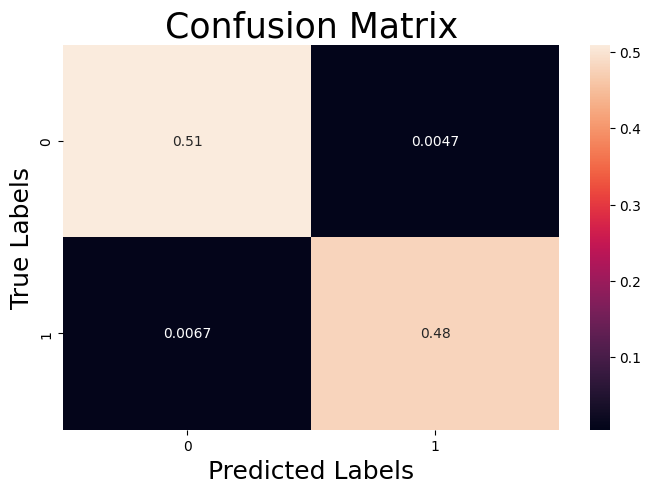

In [ ]:
# Taken and adapted from: https://keras.io/api/layers/convolution_layers/convolution1d/

# Data Preparation
X = data['text']
y = data['label']

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Text Vectorization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded,
                                                    test_size=0.2,
                                                    random_state=42)

# Building the CNN Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=50, input_length=100))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' if you have more than two classes

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Let's evaluate it
model.evaluate(X_test, y_test)

# Lets predict something
predicted_CNN_model = model.predict(X_test)

# Now let's try to graph that model

# This is where I'll store the predictions
binary_predictions = []

# Let's place the predicted values into buckets and then into my storage
for i in predicted_CNN_model:
    # If it was higher/equal to 0.5, it's a 1 (true)
    if i >= 0.5:
        binary_predictions.append(1)
    # It's false
    else:
        binary_predictions.append(0)

# lets fill out the confusion matrix with values
matrix_of_confusion = confusion_matrix(binary_predictions, y_test,
                                       normalize='all')

# Lets plot it (standard eight by 5)
plt.figure(figsize=(8, 5))

matrix_graph = plt.subplot()
# Adding a heat map
sns.heatmap(matrix_of_confusion, annot=True, ax = matrix_graph)
# Labeling and prettying it up
matrix_graph.set_xlabel('Predicted Labels', size=18)
matrix_graph.set_ylabel('True Labels', size=18)
matrix_graph.set_title('Confusion Matrix', size=25)
matrix_graph.xaxis.set_ticklabels([0,1], size=10)
matrix_graph.yaxis.set_ticklabels([0,1], size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

### On cleaned data

Epoch 1/5
1123/1123 [==============================] - 55s 48ms/step - loss: 0.1237 - accuracy: 0.9511 - val_loss: 0.0665 - val_accuracy: 0.9751
Epoch 2/5
1123/1123 [==============================] - 13s 12ms/step - loss: 0.0250 - accuracy: 0.9920 - val_loss: 0.0565 - val_accuracy: 0.9825
Epoch 3/5
1123/1123 [==============================] - 9s 8ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.0730 - val_accuracy: 0.9821
Epoch 4/5
1123/1123 [==============================] - 9s 8ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0779 - val_accuracy: 0.9826
Epoch 5/5
281/281 [==============================] - 1s 3ms/step - loss: 0.0854 - accuracy: 0.9824
Test Accuracy: 98.24%


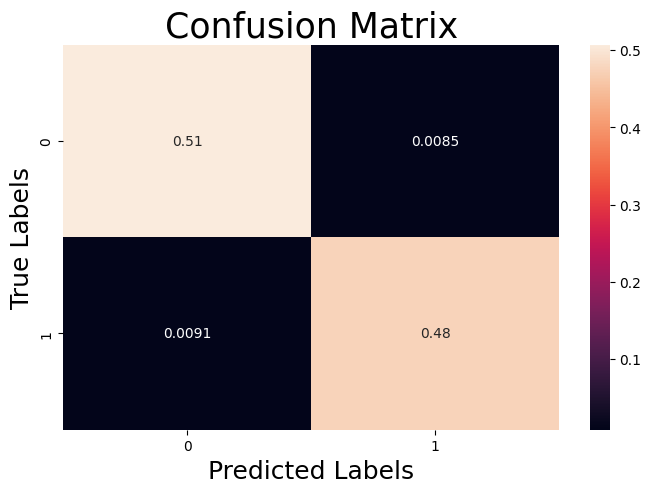

In [ ]:
# Data Preparation
X = data['no_stopwords']
y = data['label']

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Text Vectorization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded,
                                                    test_size=0.2, random_state=42)

# Building the CNN Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=50, input_length=100))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' if you have more than two classes

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Let's evaluate it
model.evaluate(X_test, y_test)

# Lets predict something
predicted_CNN_model = model.predict(X_test)

# Now let's try to graph that model

# This is where I'll store the predictions
binary_predictions = []

# Let's place the predicted values into buckets and then into my storage
for i in predicted_CNN_model:
    # If it was higher/equal to 0.5, it's a 1 (true)
    if i >= 0.5:
        binary_predictions.append(1)
    # It's false
    else:
        binary_predictions.append(0)

# lets fill out the confusion matrix with values
matrix_of_confusion = confusion_matrix(binary_predictions, y_test,
                                       normalize='all')

# Lets plot it (standard eight by 5)
plt.figure(figsize=(8, 5))

matrix_graph = plt.subplot()
# Adding a heat map
sns.heatmap(matrix_of_confusion, annot=True, ax = matrix_graph)
# Labeling and prettying it up
matrix_graph.set_xlabel('Predicted Labels', size=18)
matrix_graph.set_ylabel('True Labels', size=18)
matrix_graph.set_title('Confusion Matrix', size=25)
matrix_graph.xaxis.set_ticklabels([0,1], size=10)
matrix_graph.yaxis.set_ticklabels([0,1], size=10)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

#### Conclusion on CNN

On raw data, we get an accuracy of: 98.86%

On cleaned data, we get an accuracy of: 98.24%

In CNN cleaning the data affects the accurary, it is more accurate to use the raw data yet again!

## Now, CNN + bidirectional LSTM

### On raw data

Epoch 1/10
1123/1123 [==============================] - 29s 22ms/step - loss: 0.0314 - accuracy: 0.9864 - val_loss: 0.0055 - val_accuracy: 0.9987
Epoch 2/10
1123/1123 [==============================] - 12s 11ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0054 - val_accuracy: 0.9986
Epoch 3/10
1123/1123 [==============================] - 12s 10ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0087 - val_accuracy: 0.9972
Epoch 4/10
1123/1123 [==============================] - 11s 10ms/step - loss: 5.2560e-04 - accuracy: 0.9999 - val_loss: 0.0061 - val_accuracy: 0.9986
Epoch 5/10
1123/1123 [==============================] - 10s 9ms/step - loss: 3.2503e-04 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9989
Epoch 6/10
1123/1123 [==============================] - 12s 11ms/step - loss: 3.2897e-04 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 0.9984
Epoch 7/10
1123/1123 [==============================] - 11s 10ms/step - loss: 2.8137e-04 - accuracy: 1.0000 - val

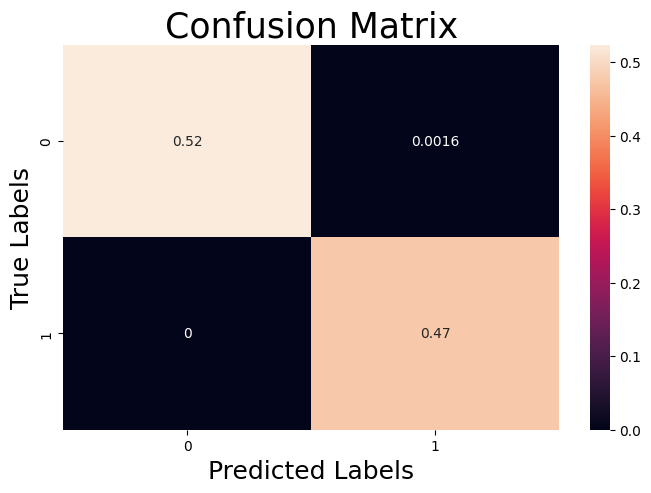

In [ ]:
# Taken and adapted from: https://stackoverflow.com/questions/64150587/combining-cnn-and-bidirectional-lstm

# Parameters
vocab_size = 10000
embedding_dim = 64
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Tokenize the data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data['text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(data['text'])
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type,
                       truncating=trunc_type)

# Split data into training and testing (example split)
train_size = int(len(data) * 0.8)
train_sequences = padded[0:train_size]
train_labels = data['label'][0:train_size]
test_sequences = padded[train_size:]
test_labels = data['label'][train_size:]

# Building the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

# Train the model
model.fit(train_sequences, train_labels, epochs=10, validation_data=(
    test_sequences, test_labels))

# Let's evaluate it
model.evaluate(test_sequences, test_labels)

# Lets predict something
predicted_CNN_LSTM_model = model.predict(test_sequences)

# Now let's try to graph that model

# This is where I'll store the predictions
binary_predictions = []

# Let's place the predicted values into buckets and then into my storage
for i in predicted_CNN_LSTM_model:
    # If it was higher/equal to 0.5, it's a 1 (true)
    if i >= 0.5:
        binary_predictions.append(1)
    # It's false
    else:
        binary_predictions.append(0)

# lets fill out the confusion matrix with values
matrix_of_confusion = confusion_matrix(binary_predictions, test_labels,
                                       normalize='all')

# Lets plot it (standard eight by 5)
plt.figure(figsize=(8, 5))

matrix_graph = plt.subplot()
# Adding a heat map
sns.heatmap(matrix_of_confusion, annot=True, ax = matrix_graph)
# Labeling and prettying it up
matrix_graph.set_xlabel('Predicted Labels', size=18)
matrix_graph.set_ylabel('True Labels', size=18)
matrix_graph.set_title('Confusion Matrix', size=25)
matrix_graph.xaxis.set_ticklabels([0,1], size=10)
matrix_graph.yaxis.set_ticklabels([0,1], size=10)

# Evaluate the model
loss, accuracy = model.evaluate(test_sequences, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

### On cleaned data

Epoch 1/10
1123/1123 [==============================] - 42s 34ms/step - loss: 0.0351 - accuracy: 0.9853 - val_loss: 0.0068 - val_accuracy: 0.9981
Epoch 2/10
1123/1123 [==============================] - 14s 12ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0068 - val_accuracy: 0.9986
Epoch 3/10
1123/1123 [==============================] - 12s 10ms/step - loss: 7.4110e-04 - accuracy: 0.9999 - val_loss: 0.0082 - val_accuracy: 0.9983
Epoch 4/10
1123/1123 [==============================] - 11s 10ms/step - loss: 5.1769e-04 - accuracy: 0.9998 - val_loss: 0.0105 - val_accuracy: 0.9968
Epoch 5/10
1123/1123 [==============================] - 12s 11ms/step - loss: 9.2159e-04 - accuracy: 0.9998 - val_loss: 0.0069 - val_accuracy: 0.9989
Epoch 6/10
1123/1123 [==============================] - 13s 12ms/step - loss: 7.5634e-04 - accuracy: 0.9998 - val_loss: 0.0085 - val_accuracy: 0.9987
Epoch 7/10
1123/1123 [==============================] - 10s 9ms/step - loss: 2.8030e-04 - accuracy: 1.0000 -

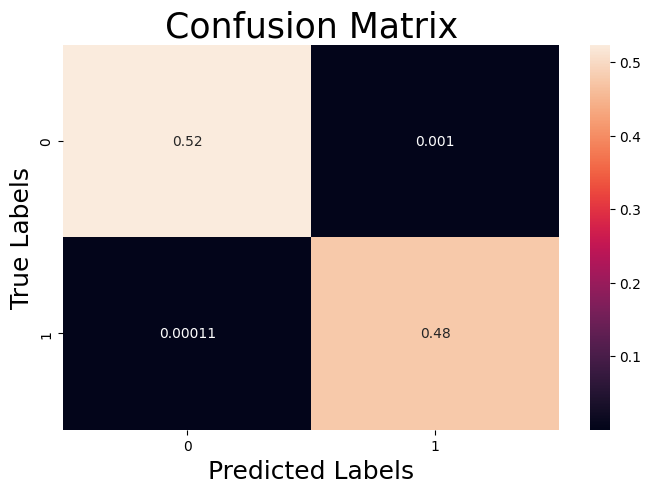

In [ ]:
# Parameters
vocab_size = 10000
embedding_dim = 64
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Tokenize the data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data['no_stopwords'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(data['no_stopwords'])
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type,
                       truncating=trunc_type)

# Split data into training and testing (example split)
train_size = int(len(data) * 0.8)
train_sequences = padded[0:train_size]
train_labels = data['label'][0:train_size]
test_sequences = padded[train_size:]
test_labels = data['label'][train_size:]

# Building the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

# Train the model
model.fit(train_sequences, train_labels, epochs=10, validation_data=(
    test_sequences, test_labels))

# Let's evaluate it
model.evaluate(test_sequences, test_labels)

# Lets predict something
predicted_CNN_LSTM_model = model.predict(test_sequences)

# Now let's try to graph that model

# This is where I'll store the predictions
binary_predictions = []

# Let's place the predicted values into buckets and then into my storage
for i in predicted_CNN_LSTM_model:
    # If it was higher/equal to 0.5, it's a 1 (true)
    if i >= 0.5:
        binary_predictions.append(1)
    # It's false
    else:
        binary_predictions.append(0)

# lets fill out the confusion matrix with values
matrix_of_confusion = confusion_matrix(binary_predictions, test_labels,
                                       normalize='all')

# Lets plot it (standard eight by 5)
plt.figure(figsize=(8, 5))

matrix_graph = plt.subplot()
# Adding a heat map
sns.heatmap(matrix_of_confusion, annot=True, ax = matrix_graph)
# Labeling and prettying it up
matrix_graph.set_xlabel('Predicted Labels', size=18)
matrix_graph.set_ylabel('True Labels', size=18)
matrix_graph.set_title('Confusion Matrix', size=25)
matrix_graph.xaxis.set_ticklabels([0,1], size=10)
matrix_graph.yaxis.set_ticklabels([0,1], size=10)

# Evaluate the model
loss, accuracy = model.evaluate(test_sequences, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

#### Conclusion on CNN + bidirectional LSTM

On raw data, we get an accuracy of: 99.84%

On cleaned data, we get an accuracy of: 99.89%

Now this makes more sense, with CNN + bidirectional LSTM cleaning the data affects the accurary, it is better to use clean data to get more accuracy.

99.84% is the best I've seen!

# Summary and conclusions

## Algoritms
Bayes was our baseline, simple and a low bar.

Simple RNN was a high bar, we selected it because it was mentioned more than once on the research papers.

GRU was a clear next bar, better than SimpleRNN but requiered more computing power.

LSTM, CNN and CNN+Bidirectional LSTM, was something we also read from the research papers, adding two layers was something new and required the most computational power i have ever done (this requiered that I pay for credits on Google Colab, otherwise it woudl have taken days to execute on the free version)

## Conclusion
Better algorithms are heavier and requiere more computeing power, researching them and implementing them is not easy and the worse part is modifying the parameters to be able to run in hours and not days.

I was able to run everything in a few hours only becuase I was able to pay for Google Colab.

In my computer, it would have taken days (I have an old computer Intel i3 from 5 years ago)

Reaching over 99% was a dream, I took weeks of testing each algoritm to be able to run them in my computer, it was a shocking experience runing them in Google Colab after paying, it took minutes instead of hours and days.

I learned that in order to trully be able to do this, you need good computing power, everything else just consumes your patience and life.


